In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
from datetime import datetime
import seaborn as sns

from itertools import chain, permutations
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import os

from pandas_datareader import fred
import yfinance as yf
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank, select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def adf_test_summary(ser):
    # ADF H0: there is a unit root

    specs = {'constant': 'c', 'constant trend': 'ct', 'constant ltend, qtrend': 'ctt', 'none': 'n'}
    results = {}

    for pretty, spec in specs.items():
        adf, pval, ulag, nobs, cval, icb = adfuller(ser, regression=spec)
        keys = ['adf-stat', 'p-value', 'lags', 'obs', *cval.keys(), 'inf crit']
        res = [adf, pval, ulag, nobs, *cval.values(), icb]
        results[pretty] = dict(zip(keys, res))

    if ser.name is not None:
        title = ser.name.upper()
    else:
        title = ''

    print('-' * 77)
    print(f'ADF Test {title}: H0 there is a unit root')
    print('-' * 77)
    print(pd.DataFrame(results).transpose().round(3).iloc[:, :-1])
    print('\n')

    pass


from io import StringIO
import sys


class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self

    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio
        sys.stdout = self._stdout


def plot_df(df, n_cols: int = 3, fig_size: tuple = (5, 2)):
    n_cols = min(n_cols, df.shape[1])
    rows = int(np.ceil(df.shape[1] / n_cols))

    fig, axes = plt.subplots(rows, n_cols, figsize=(n_cols * fig_size[0], rows * fig_size[1]))
    for i, ax in enumerate(axes.reshape(-1)):
        if i > df.shape[1] - 1: continue
        ax.plot(df.iloc[:, i].dropna())
        ax.set_title(df.iloc[:, i].name)

    plt.tight_layout()
    return fig, axes


In [97]:
data = pd.read_csv('/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Financial Econometrics/Project/Data/fred.csv')

In [98]:
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame

# Set 'DATE' column as the index
data.set_index('DATE', inplace=True)

# Rename columns
data.rename(columns={'WILL5000PR': 'lwill', 'GDPC1': 'lgdp', 'FEDFUNDS': 'ir'}, inplace=True)

# Replace '.' with NaN
data.replace('.', np.nan, inplace=True)

# Convert columns to numeric, assuming they are not already
data = data.apply(pd.to_numeric, errors='ignore')

# Take the logarithm of 'lwill' and 'lgdp' columns
data['lwill'] = np.log(data['lwill'])
data['lgdp'] = np.log(data['lgdp'])

In [99]:
data.dropna(how='any', inplace=True)

In [100]:
data['ret'] = data['lwill'].diff()
data['dir'] = data['ir'].diff()
data['dlgdp'] = data['lgdp'].diff()

In [101]:
data.dropna(how='any', inplace=True)

In [108]:
data

,lwill,lgdp,ir,ret,dir,dlgdp
DATE,,,,,,
1971-04-01,6.837687,8.607593,4.566667,0.042052,0.710000,0.005394
1971-07-01,6.810256,8.615784,5.476667,-0.027430,0.910000,0.008191
1971-10-01,6.801557,8.618130,4.750000,-0.008699,-0.726667,0.002346
1972-01-01,6.906294,8.636335,3.546667,0.104737,-1.203333,0.018205
1972-04-01,6.928600,8.658774,4.300000,0.022306,0.753333,0.022439
...,...,...,...,...,...,...
2022-07-01,10.608814,9.992008,2.190000,-0.029614,1.420000,0.006565
2022-10-01,10.574385,9.998342,3.653333,-0.034429,1.463333,0.006334
2023-01-01,10.612783,10.003891,4.516667,0.038398,0.863333,0.005548


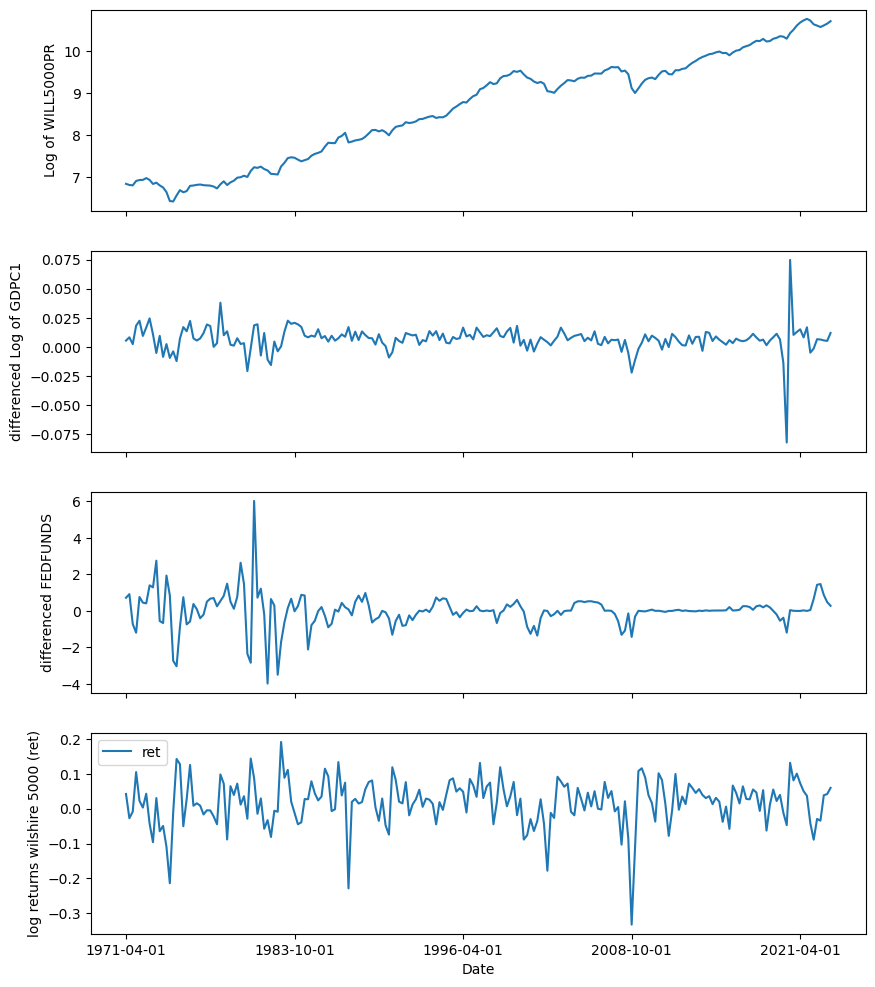

In [109]:
# Plot each series on different axes on the same figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

data['lwill'].plot(ax=ax1, label='lwill')
data['dlgdp'].plot(ax=ax2, label='dlgdp')
data['dir'].plot(ax=ax3, label='dir')
data['ret'].plot(ax=ax4, label='ret')

# Set axis labels and legend
ax1.set_ylabel('Log of WILL5000PR')
ax2.set_ylabel('differenced Log of GDPC1')
ax3.set_ylabel('differenced FEDFUNDS')
ax4.set_ylabel('log returns wilshire 5000 (ret)')

plt.xlabel('Date')
plt.legend()

# Show the plot
plt.show()

In [110]:
with Capturing() as output:
    for col in data:
        if 'log' not in col:
            adf_test_summary(data[col].dropna())

[print(i) for i in output];

-----------------------------------------------------------------------------
ADF Test LWILL: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -0.214    0.937   1.0  208.0 -3.462 -2.876 -2.574
constant trend            -2.830    0.186   1.0  208.0 -4.003 -3.432 -3.140
constant ltend, qtrend    -3.178    0.218   1.0  208.0 -4.428 -3.861 -3.571
none                       2.902    1.000   1.0  208.0 -2.577 -1.942 -1.616


-----------------------------------------------------------------------------
ADF Test LGDP: H0 there is a unit root
-----------------------------------------------------------------------------
                        adf-stat  p-value  lags    obs     1%     5%    10%
constant                  -1.598    0.485   0.0  209.0 -3.462 -2.875 -2.574
constant trend            -1.501    0.829   0.0  209.0 -4.003 -3.432 -3.140

# ARDL Model

In [111]:
data

,lwill,lgdp,ir,ret,dir,dlgdp
DATE,,,,,,
1971-04-01,6.837687,8.607593,4.566667,0.042052,0.710000,0.005394
1971-07-01,6.810256,8.615784,5.476667,-0.027430,0.910000,0.008191
1971-10-01,6.801557,8.618130,4.750000,-0.008699,-0.726667,0.002346
1972-01-01,6.906294,8.636335,3.546667,0.104737,-1.203333,0.018205
1972-04-01,6.928600,8.658774,4.300000,0.022306,0.753333,0.022439
...,...,...,...,...,...,...
2022-07-01,10.608814,9.992008,2.190000,-0.029614,1.420000,0.006565
2022-10-01,10.574385,9.998342,3.653333,-0.034429,1.463333,0.006334
2023-01-01,10.612783,10.003891,4.516667,0.038398,0.863333,0.005548


In [119]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'data' is your DataFrame with 'DATE' as the index
# Extract the relevant columns
df_ardl = data[['ret', 'dir', 'dlgdp']]

# Set the maximum number of lags to consider
max_lags = 10

# Create lagged variables
for col in df_ardl.columns:
    for i in range(1, max_lags + 1):
        df_ardl[f'{col}_lag{i}'] = df_ardl[col].shift(i)

# Drop rows with NaN resulting from creating lagged variables
df_ardl = df_ardl.dropna()

# Define the dependent variable (ret) and explanatory variables
y = df_ardl['ret']
X = df_ardl.drop(columns=['ret'])

# Initialize a DataFrame to store BIC results
bic_results = pd.DataFrame(columns=['Lags', 'BIC'])

# Loop through different lag orders and fit models
for lags in range(1, max_lags + 1):
    # Create a lagged matrix of variables
    X_lagged = X.filter(like='_lag').iloc[:, :lags]
    
    # Combine lagged variables with the current values
    X_combined = sm.add_constant(X_lagged)
    
    # Fit the model
    model = sm.OLS(y, X_combined)
    results = model.fit()
    
    # Calculate BIC and store results
    bic = results.bic
    bic_results = bic_results.append({'Lags': lags, 'BIC': bic}, ignore_index=True)

# Find the lag order with the minimum BIC
best_lag = bic_results.loc[bic_results['BIC'].idxmin()]['Lags']
print(f"Best Lag Order: {best_lag}")

# Display BIC results
print(bic_results)


Best Lag Order: 1.0
   Lags         BIC
0   1.0 -524.840197
1   2.0 -520.673003
2   3.0 -515.388167
3   4.0 -510.183458
4   5.0 -505.436433
5   6.0 -500.617944
6   7.0 -497.247914
7   8.0 -492.054237
8   9.0 -488.010783
9  10.0 -483.260559


In [124]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'data' is your DataFrame with 'ret', 'dlgdp', and 'dir' columns

# Create lagged variables
data['lag_ret'] = data['ret'].shift(1)
data['lag_dlgdp'] = data['dlgdp'].shift(1)
data['lag_dir'] = data['dir'].shift(1)

# Drop rows with missing values due to the lag
data = data.dropna()

# Specify the regression model
X = sm.add_constant(data[['lag_ret', 'dlgdp', 'lag_dlgdp', 'dir', 'lag_dir']])
y = data['ret']

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     8.917
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           1.16e-07
Time:                        12:47:04   Log-Likelihood:                 288.49
No. Observations:                 206   AIC:                            -565.0
Df Residuals:                     200   BIC:                            -545.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.006      0.409      0.6

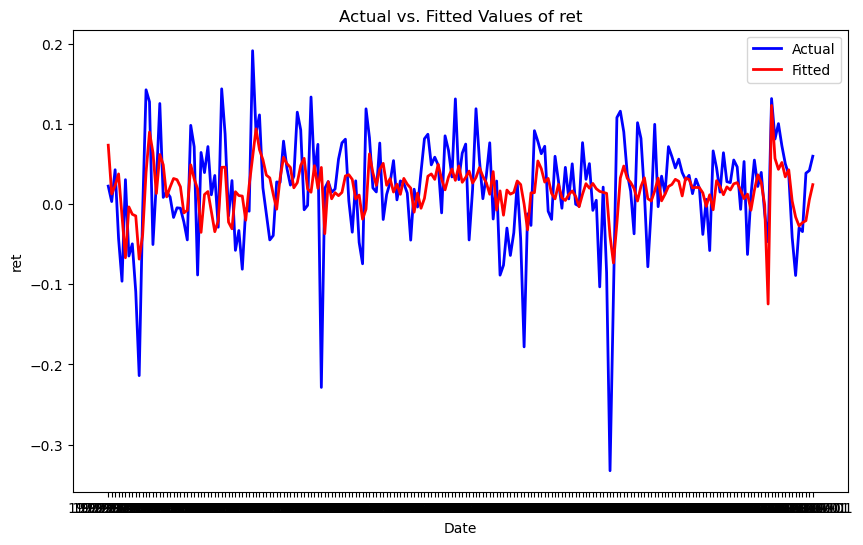

In [126]:
import matplotlib.pyplot as plt

# Plotting actual vs. fitted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['ret'], label='Actual', color='blue', linewidth=2)
plt.plot(data.index, results.fittedvalues, label='Fitted', color='red', linewidth=2)
plt.title('Actual vs. Fitted Values of ret')
plt.xlabel('Date')
plt.ylabel('ret')
plt.legend()
plt.show()



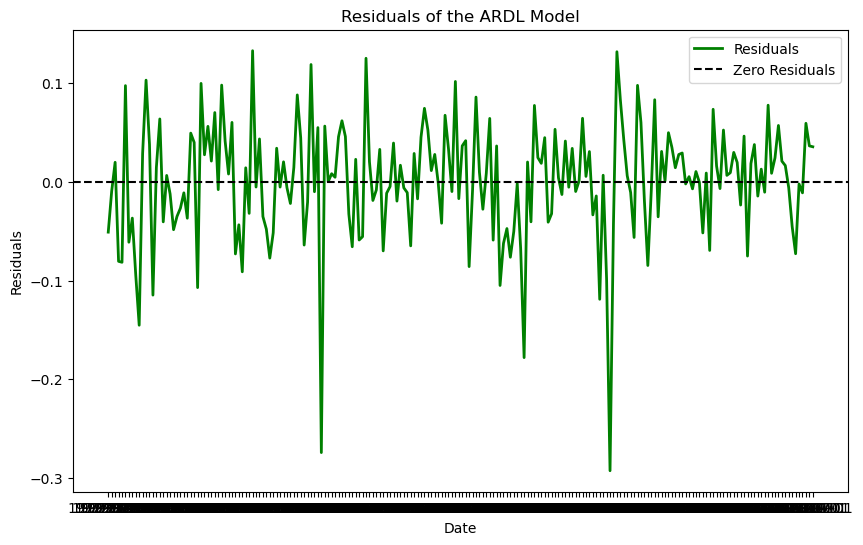

In [127]:
# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(data.index, results.resid, label='Residuals', color='green', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals of the ARDL Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [145]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mseARDL = mean_squared_error(data['ret'], results.fittedvalues)

print(f'Mean Squared Error (MSE): {mseARDL}')


Mean Squared Error (MSE): 0.003557454484003577


# Logistic Smooth Transition Regression Model

In [129]:
data.to_excel('output_data.xls', index=True, sheet_name='Sheet1')

See JMULTI LSTR model estimation.

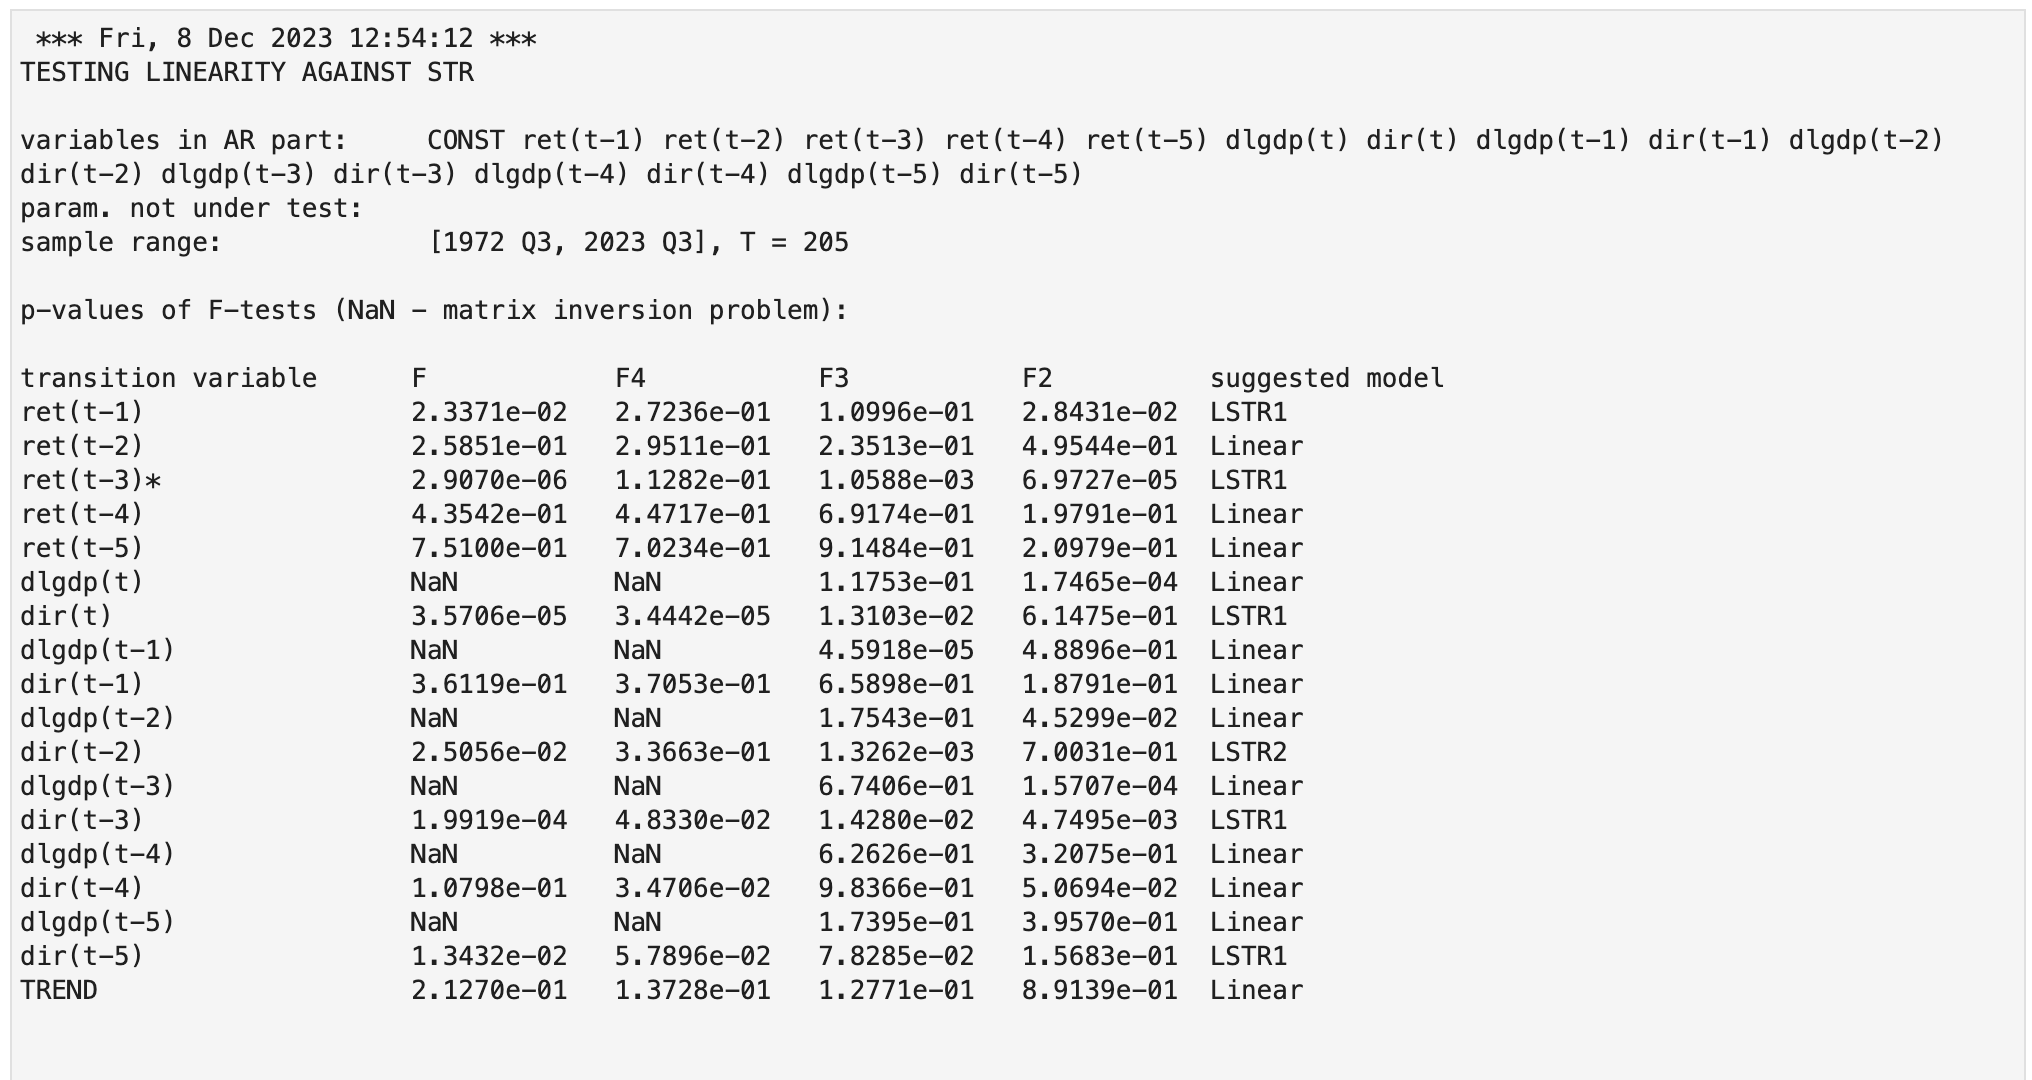

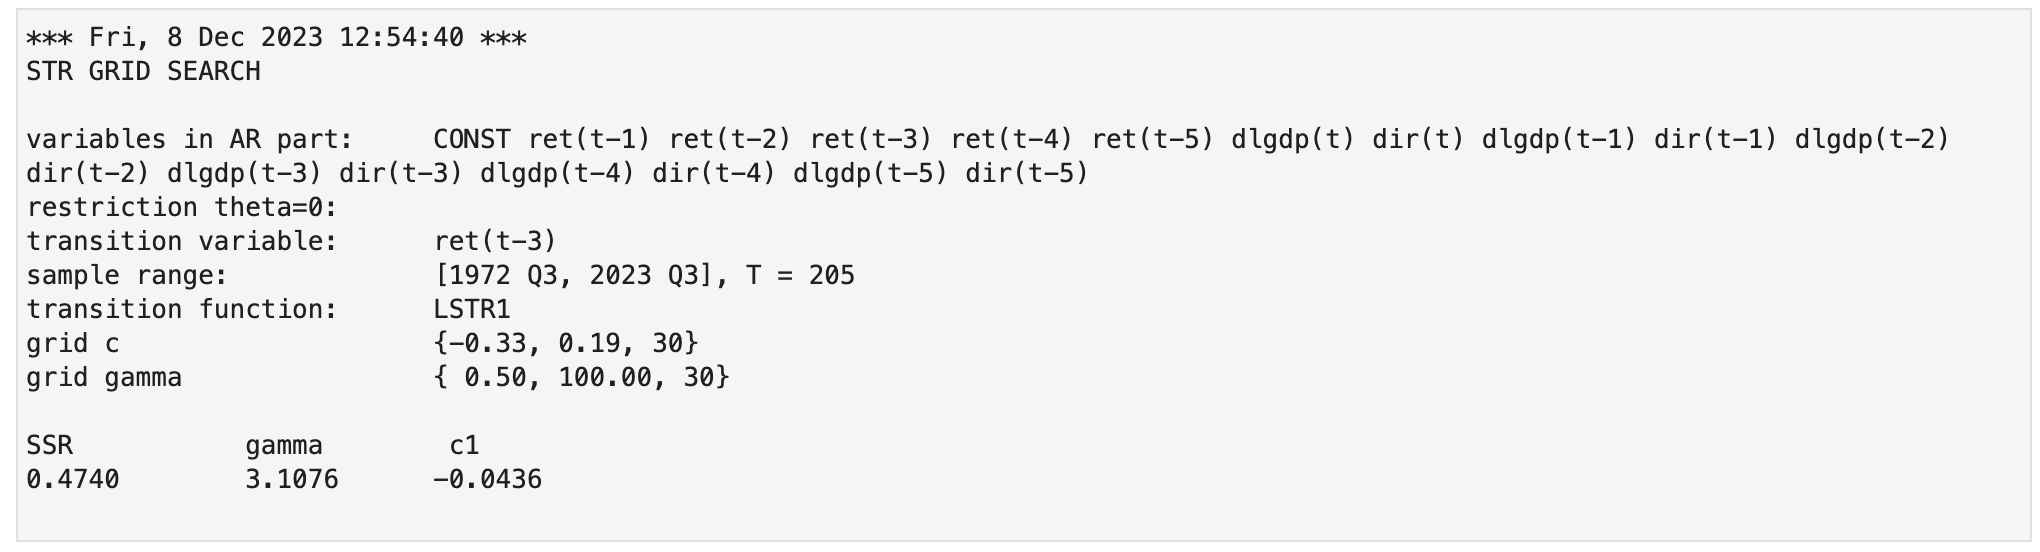

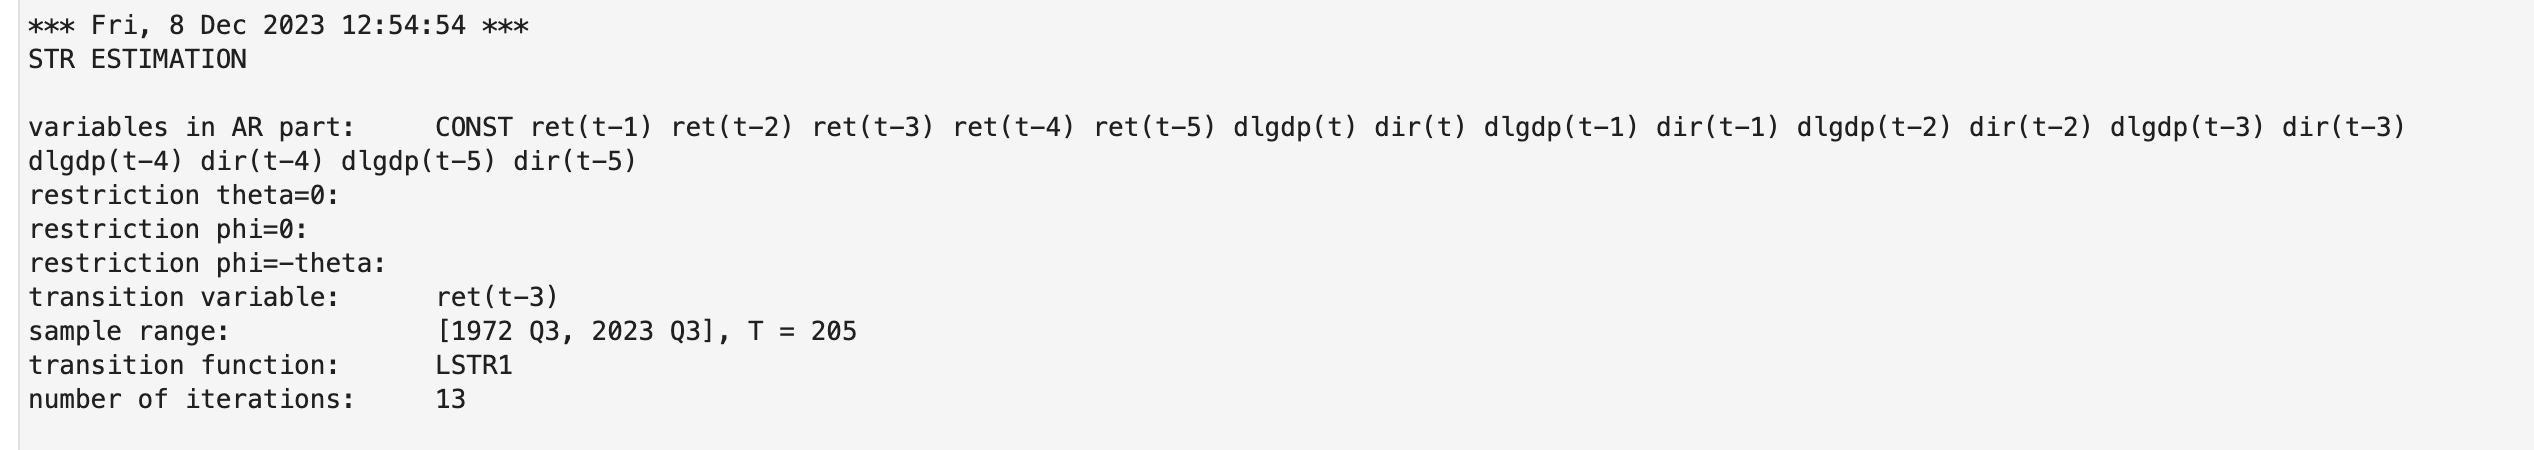

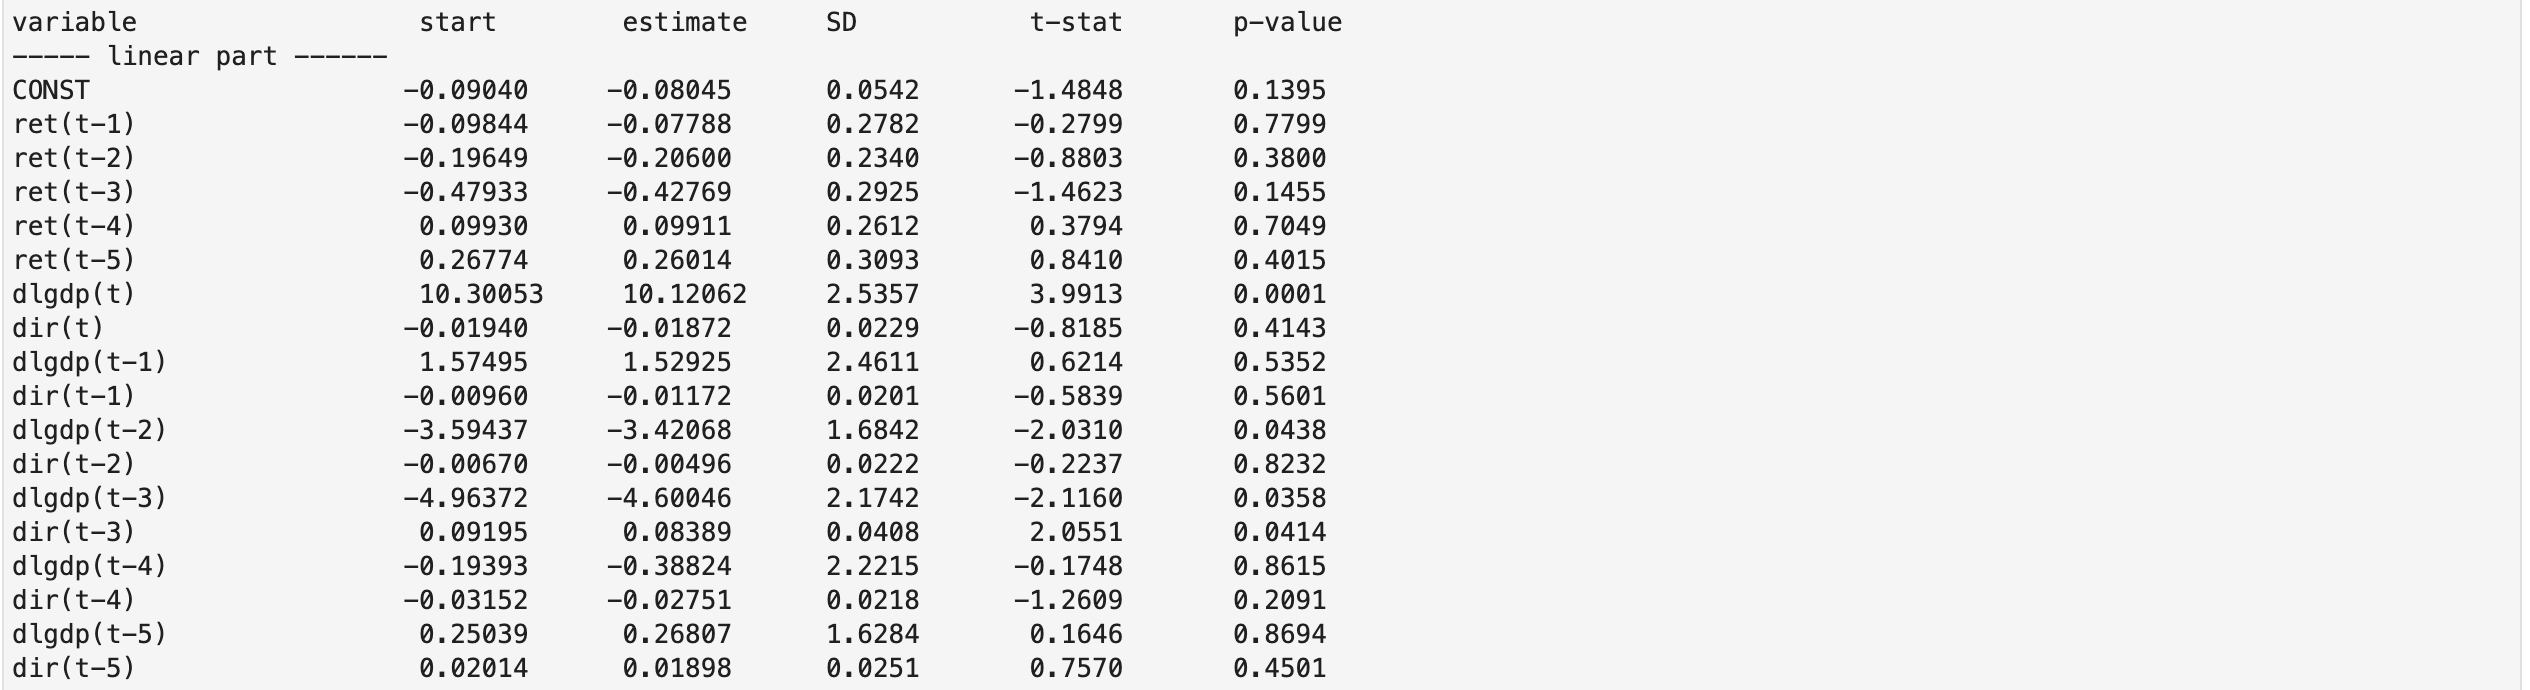

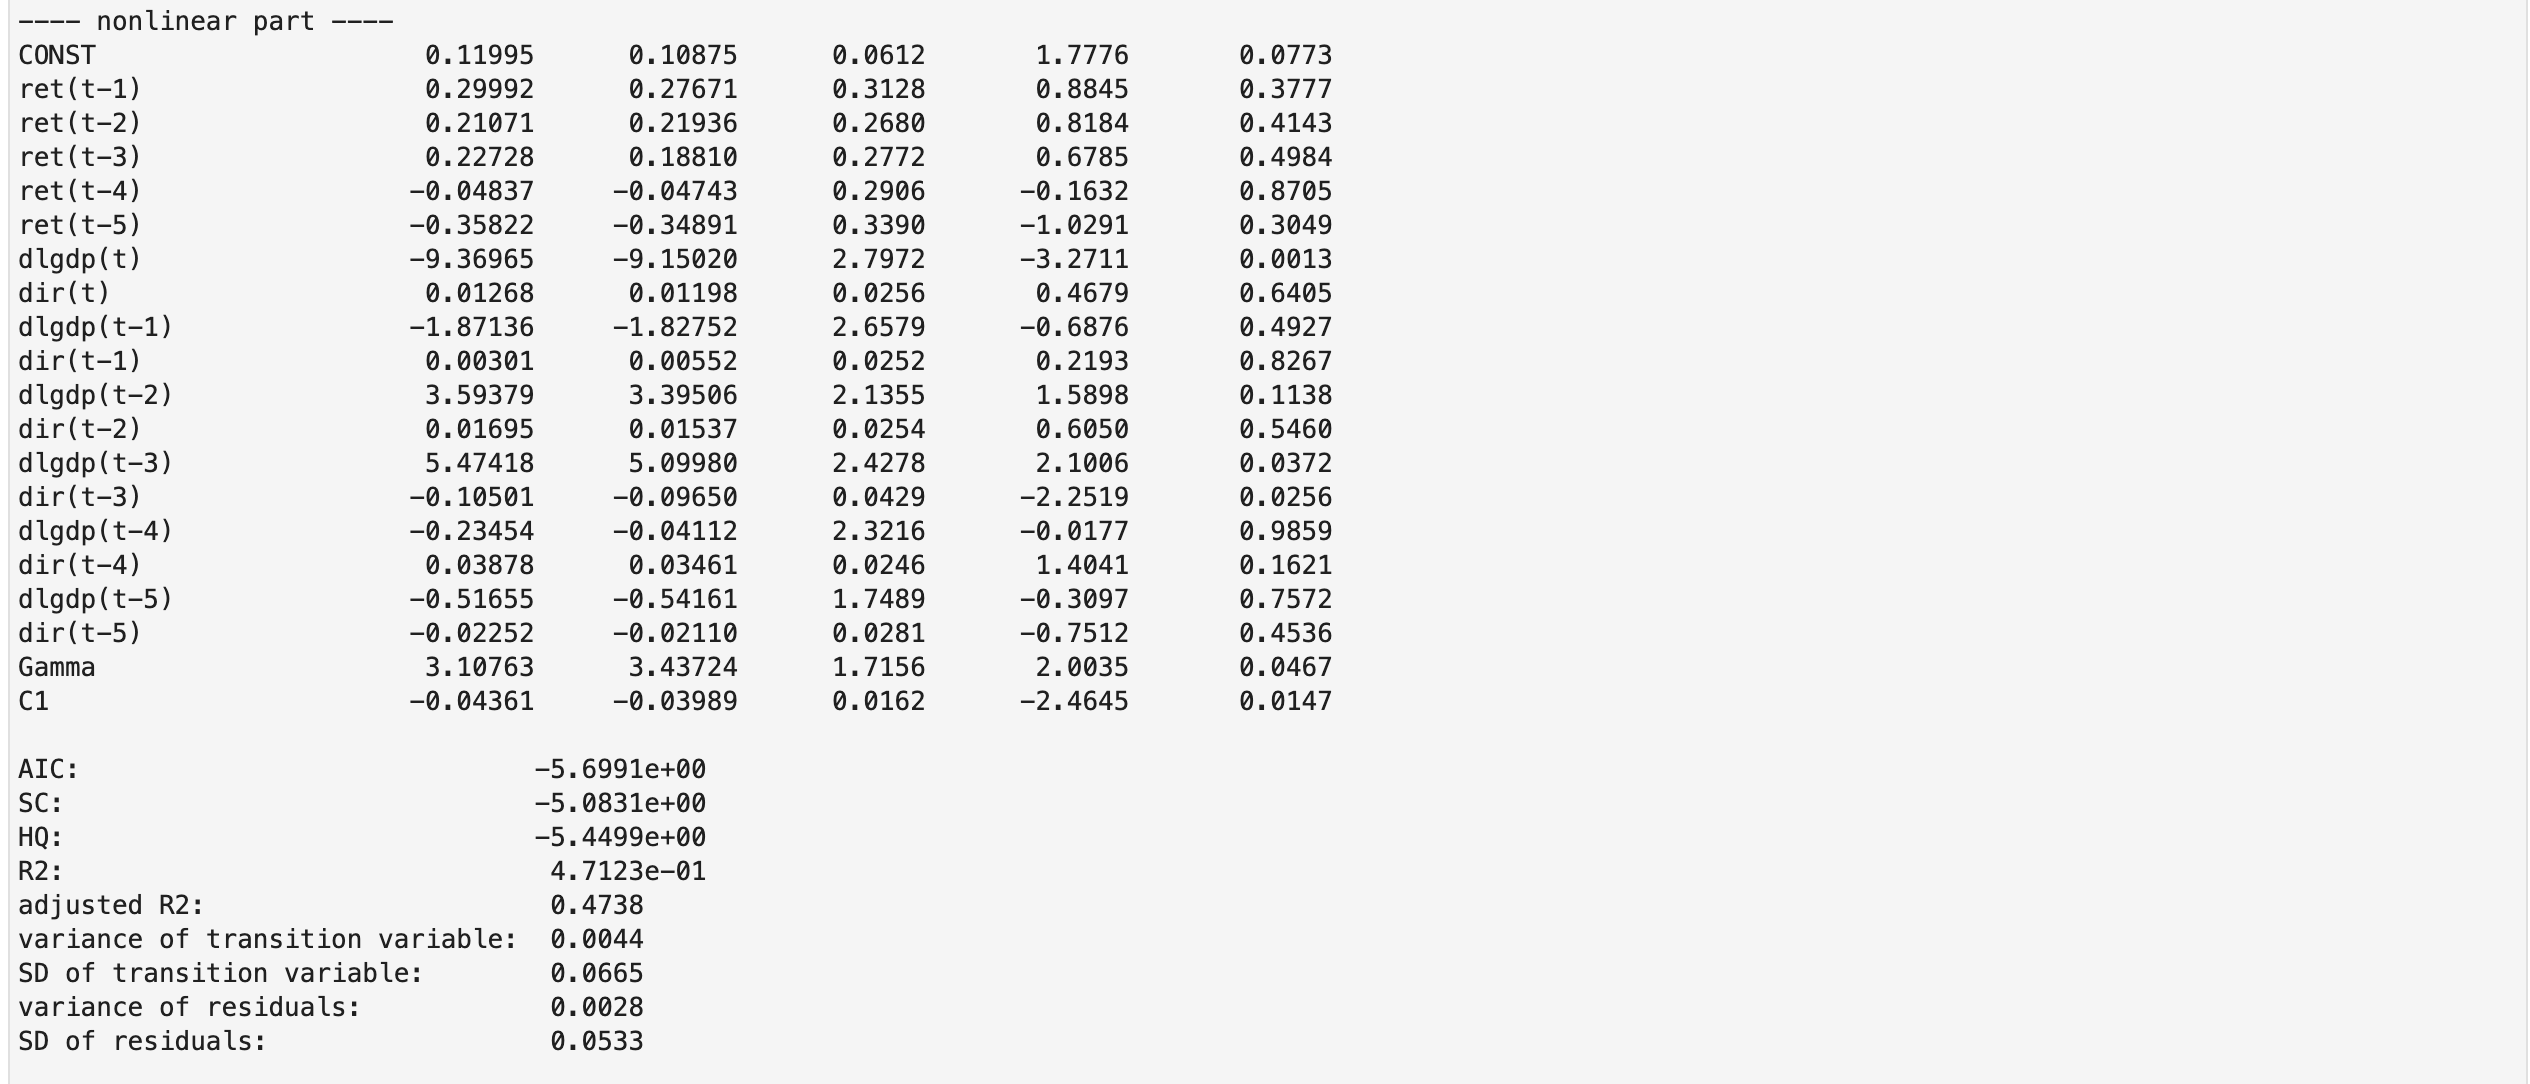

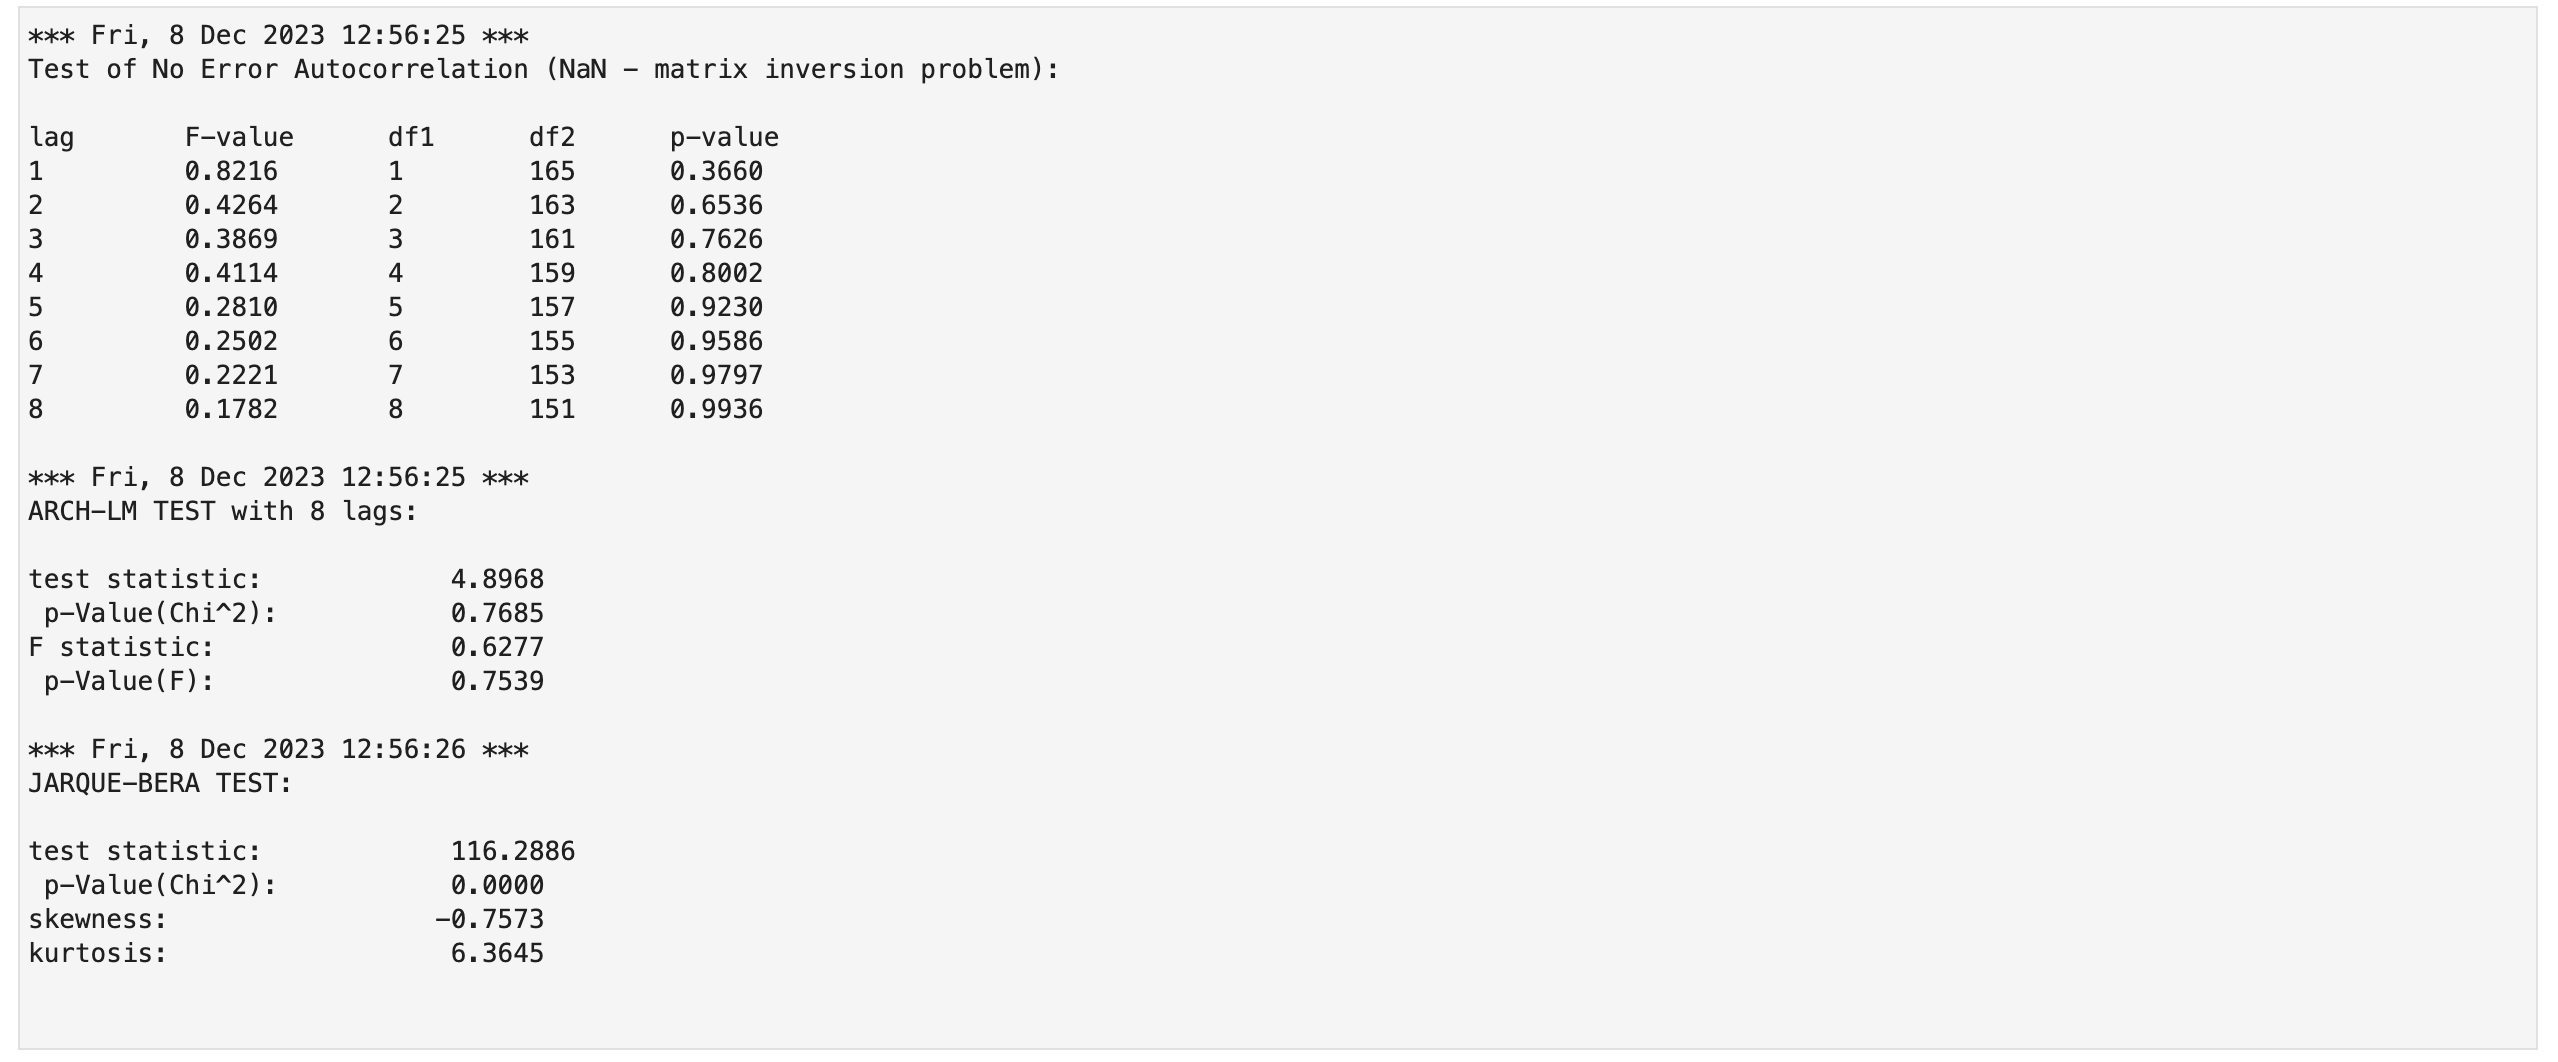

In [131]:
file_path = '/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Financial Econometrics/Project/jmulti.xlsx'

# Load Excel file into a Pandas DataFrame
df = pd.read_excel(file_path, sheet_name='Sheet1')  # You may need to specify the sheet name

In [132]:
df

,Time,Linear Part,Nonlinear Part,Fitted Series,Orig. Series,Trans. Function,Trans. Variable
0,1972 Q3,-0.1209,0.1201,-0.0008,0.0031,0.8338,-0.0087
1,1972 Q4,-0.1950,0.2300,0.0350,0.0427,0.9994,0.1047
2,1973 Q1,0.0948,-0.0572,0.0375,-0.0431,0.9614,0.0223
3,1973 Q2,-0.0632,0.0513,-0.0120,-0.0962,0.9021,0.0031
4,1973 Q3,-0.3080,0.2744,-0.0336,0.0303,0.9862,0.0427
...,...,...,...,...,...,...,...
200,2022 Q3,-0.0878,0.0786,-0.0092,-0.0296,0.9811,0.0365
201,2022 Q4,0.0291,-0.0098,0.0192,-0.0344,0.4768,-0.0417
202,2023 Q1,0.0410,-0.0009,0.0402,0.0384,0.0729,-0.0891
203,2023 Q2,-0.0002,0.0274,0.0273,0.0418,0.6298,-0.0296


In [133]:
import pandas as pd

# Assuming you already have a DataFrame 'df' with a column 'Time'
# If not, replace this line with loading your DataFrame using pd.read_excel or another method

# Extract year and quarter information
df[['Year', 'Quarter']] = df['Time'].str.extract(r'(\d{4}) Q(\d)')

# Create a new 'Date' column with the first day of the corresponding quarter
df['Date'] = pd.to_datetime(df['Year'] + '-' + df['Quarter'].map({'1': '01', '2': '04', '3': '07', '4': '10'}) + '-01')

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Drop the unnecessary columns
df.drop(['Time', 'Year', 'Quarter'], axis=1, inplace=True)

df


,Linear Part,Nonlinear Part,Fitted Series,Orig. Series,Trans. Function,Trans. Variable
Date,,,,,,
1972-07-01,-0.1209,0.1201,-0.0008,0.0031,0.8338,-0.0087
1972-10-01,-0.1950,0.2300,0.0350,0.0427,0.9994,0.1047
1973-01-01,0.0948,-0.0572,0.0375,-0.0431,0.9614,0.0223
1973-04-01,-0.0632,0.0513,-0.0120,-0.0962,0.9021,0.0031
1973-07-01,-0.3080,0.2744,-0.0336,0.0303,0.9862,0.0427
...,...,...,...,...,...,...
2022-07-01,-0.0878,0.0786,-0.0092,-0.0296,0.9811,0.0365
2022-10-01,0.0291,-0.0098,0.0192,-0.0344,0.4768,-0.0417
2023-01-01,0.0410,-0.0009,0.0402,0.0384,0.0729,-0.0891


In [135]:
import pandas as pd

# Replace the file path with your actual file path
file_path = "/Users/joelthomas/Library/CloudStorage/OneDrive-Personal/Documents/My Documents/UNIVERSITY/Masters/M2 Finance/Financial Econometrics/Project/str_resids.csv"

# Read the CSV file
df_csv = pd.read_csv(file_path)

In [136]:
df_csv.dropna(inplace=True)

In [137]:
# Assuming 'Date' is the name of the column containing date values
df_csv['Date'] = pd.to_datetime(df_csv['DATE'])  # Convert 'Date' to datetime format
df_csv.set_index('Date', inplace=True)  # Set 'Date' as the index in-place

In [138]:
df_csv.drop(columns=['DATE'], inplace=True)

In [139]:
df_csv

,str_resids
Date,
1972-04-01,0.003843
1972-07-01,0.007685
1972-10-01,-0.080570
1973-01-01,-0.084256
1973-04-01,0.063938
...,...
2022-04-01,-0.020378
2022-07-01,-0.053652
2022-10-01,-0.001760


In [140]:
lstr_est = pd.merge(df_csv, df, left_index=True, right_index=True, how='inner')
lstr_est

,str_resids,Linear Part,Nonlinear Part,Fitted Series,Orig. Series,Trans. Function,Trans. Variable
Date,,,,,,,
1972-07-01,0.007685,-0.1209,0.1201,-0.0008,0.0031,0.8338,-0.0087
1972-10-01,-0.080570,-0.1950,0.2300,0.0350,0.0427,0.9994,0.1047
1973-01-01,-0.084256,0.0948,-0.0572,0.0375,-0.0431,0.9614,0.0223
1973-04-01,0.063938,-0.0632,0.0513,-0.0120,-0.0962,0.9021,0.0031
1973-07-01,-0.073959,-0.3080,0.2744,-0.0336,0.0303,0.9862,0.0427
...,...,...,...,...,...,...,...
2022-04-01,-0.020378,-0.2030,0.1932,-0.0098,-0.0891,0.9906,0.0502
2022-07-01,-0.053652,-0.0878,0.0786,-0.0092,-0.0296,0.9811,0.0365
2022-10-01,-0.001760,0.0291,-0.0098,0.0192,-0.0344,0.4768,-0.0417


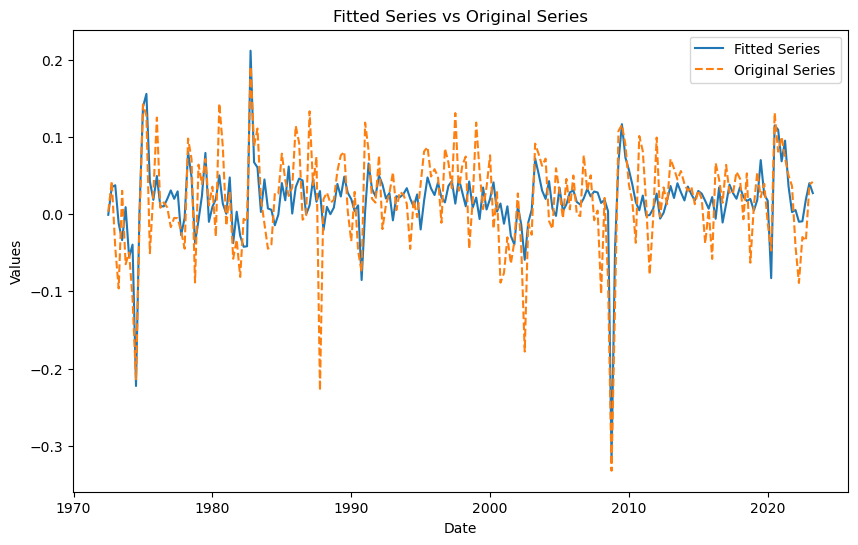

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(lstr_est.index, lstr_est['Fitted Series'], label='Fitted Series')
plt.plot(lstr_est.index, lstr_est['Orig. Series'], label='Original Series', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Fitted Series vs Original Series')
plt.legend()
plt.show()

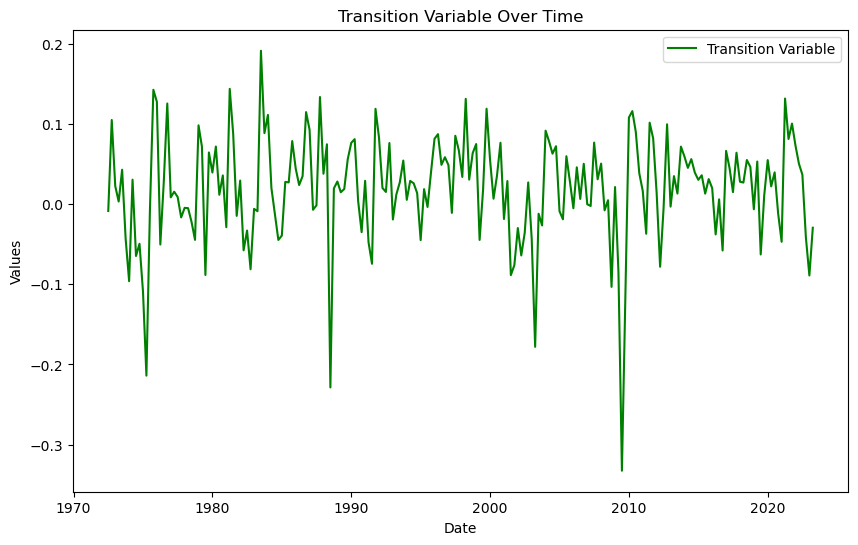

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(lstr_est.index, lstr_est['Trans. Variable'], label='Transition Variable', color='green')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Transition Variable Over Time')
plt.legend()
plt.show()

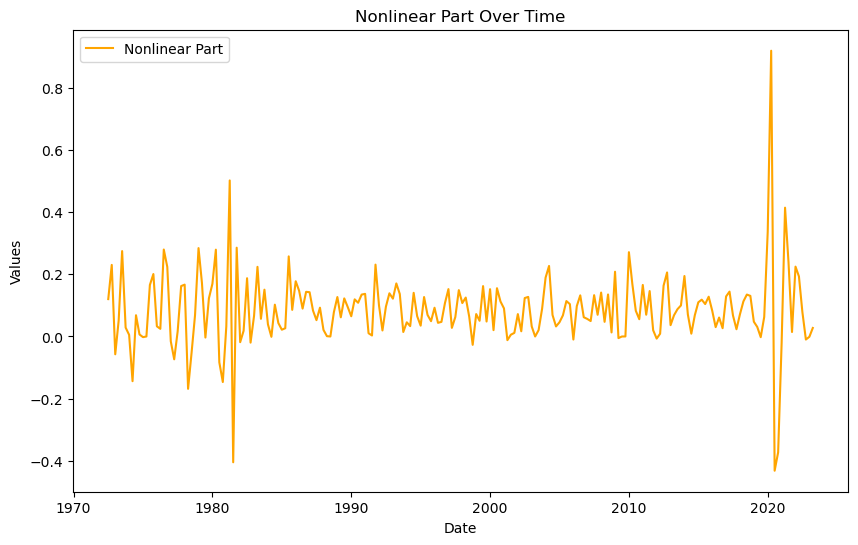

In [143]:
plt.figure(figsize=(10, 6))
plt.plot(lstr_est.index, lstr_est['Nonlinear Part'], label='Nonlinear Part', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Nonlinear Part Over Time')
plt.legend()
plt.show()

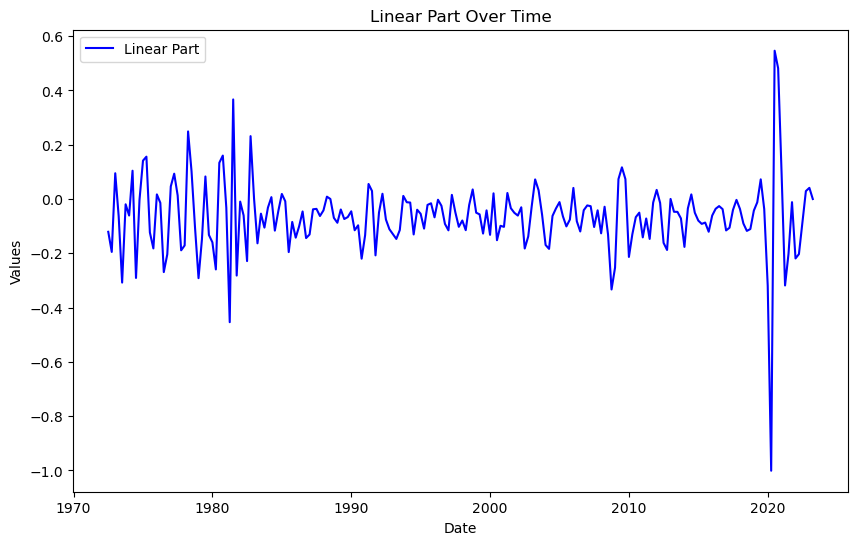

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(lstr_est.index, lstr_est['Linear Part'], label='Linear Part', color='blue')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Linear Part Over Time')
plt.legend()
plt.show()

In [147]:
from sklearn.metrics import mean_squared_error
mseLSTR = mean_squared_error(lstr_est['Orig. Series'], lstr_est['Fitted Series'])
print(f'Mean Squared Error (MSE) LSTR: {mseLSTR}')
print(f'Mean Squared Error (MSE) ARDL: {mseARDL}')



Mean Squared Error (MSE) LSTR: 0.0023230940686274513
Mean Squared Error (MSE) ARDL: 0.003557454484003577
